In [10]:
import pandas as pd

# 데이터 로딩
df_all = pd.read_csv('/home/kng/GO-AROUND/DeepSVDD/59개59개 빼고 남은거(학습용데이터)(로그변환).csv')
df_go = pd.read_csv('/home/kng/GO-AROUND/DeepSVDD/고어라운드_된_날씨_합친_59개_로그변환(test).csv')

# 전처리 (필요 시 strip 등)
df_all.columns = df_all.columns.str.strip()
df_go.columns = df_go.columns.str.strip()

# 고어라운드 여부 컬럼 추가
df_all['goaround'] = 0
df_go['goaround'] = 1

# 두 데이터 병합
df_all_combined = pd.concat([df_all, df_go], ignore_index=True)

# 중복 제거 (겹치는 샘플이 있다면)
df_all_combined.drop_duplicates(inplace=True)


In [11]:
df_all_combined

,최저운고(m),기온(0.1c),이슬점온도(0.1c),해면기압 QFF (0.1hPa),현지기압 QFE (0.1hPa),강수량 (0.1mm),2분 평균풍속 (0.1m/s),2분 최대풍속 (0.1m/s),10분 평균풍향 (degree),10분 최우풍향: 평균풍향을 기준으로 시계방향으로 스캔하여 첫번째 값 (degree),10분 평균풍속 (0.1m/s),10분 최대풍속 (0.1m/s),goaround
0,7.863651,4.369448,2.833213,9.236885,9.233764,0.000000,3.784190,4.143135,3.044522,3.044522,3.806662,4.418841,0
1,7.901377,4.369448,2.772589,9.236982,9.233959,0.000000,3.970292,4.330733,3.433987,3.433987,3.784190,4.406719,0
2,8.039480,4.343805,1.609438,9.237177,9.234057,0.000000,2.890372,3.332205,3.931826,3.931826,3.258097,3.850148,0
3,8.071219,4.304065,1.791759,9.237274,9.234252,0.000000,2.484907,3.135494,5.017280,5.081404,2.484907,3.135494,0
4,8.160804,4.290459,1.945910,9.237664,9.234545,0.000000,3.091042,3.258097,5.017280,5.081404,3.178054,3.465736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,10.126631,5.198497,4.852030,9.236106,9.233178,0.000000,4.394449,4.663439,4.700480,4.941642,4.356709,4.718499,1
5804,8.881836,4.919981,4.867534,9.229947,9.227001,2.079442,3.433987,3.806662,4.605170,4.867534,3.555348,4.248495,1
5805,8.242756,4.532599,3.806662,9.232982,9.229947,0.000000,3.465736,3.931826,5.768321,5.886104,3.555348,4.077537,1
5806,8.268732,4.290459,2.772589,9.234838,9.231710,3.091042,4.330733,4.779123,5.703782,5.828946,4.304065,4.820282,1


In [12]:
selected_features = [
    "최저운고(m)",
    "기온(0.1c)",
    "이슬점온도(0.1c)",
    "해면기압 QFF (0.1hPa)",
    "현지기압 QFE (0.1hPa)",
    "강수량 (0.1mm)",
    "2분 평균풍속 (0.1m/s)",
    "2분 최대풍속 (0.1m/s)",
    "10분 평균풍향 (degree)",
    "10분 최우풍향: 평균풍향을 기준으로 시계방향으로 스캔하여 첫번째 값 (degree)",
    "10분 평균풍속 (0.1m/s)",
    "10분 최대풍속 (0.1m/s)",
]

X = df_all_combined[selected_features]
y = df_all_combined['goaround']


In [13]:
##### train_test 분할 / 증강 / 정규화 #####

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTEENN 적용
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f'Before resampling: {pd.Series(y_train).value_counts().to_dict()}')
print(f'After resampling:  {pd.Series(y_resampled).value_counts().to_dict()}')





Before resampling: {0: 4024, 1: 41}
After resampling:  {1: 4013, 0: 3762}


In [14]:
##### 모델 학습 #####
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from collections import Counter

counter = Counter(y_resampled)
scale_pos_weight = counter[0] / counter[1]

model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',     # 또는 'auc', 'error', 'logloss' 등
    max_depth=6,
    min_child_weight=1.1,
    early_stopping_rounds=20
)

model.fit(
    X_resampled, y_resampled,
    eval_set=[(X_test_scaled, y_test)],
    verbose=True
)
# y_proba = model.predict_proba(X_test_scaled)[:, 1]
# threshold = 0.4  # 실험적으로 조절
# y_pred = (y_proba >= threshold).astype(int)


# print(classification_report(y_test, y_pred))


[0]	validation_0-auc:0.84002
[1]	validation_0-auc:0.86274
[2]	validation_0-auc:0.85382
[3]	validation_0-auc:0.85890
[4]	validation_0-auc:0.85390
[5]	validation_0-auc:0.84691
[6]	validation_0-auc:0.84150
[7]	validation_0-auc:0.83129
[8]	validation_0-auc:0.82905
[9]	validation_0-auc:0.83485
[10]	validation_0-auc:0.83034
[11]	validation_0-auc:0.81862
[12]	validation_0-auc:0.84340
[13]	validation_0-auc:0.84691
[14]	validation_0-auc:0.84871
[15]	validation_0-auc:0.85039
[16]	validation_0-auc:0.85116
[17]	validation_0-auc:0.86741
[18]	validation_0-auc:0.86847
[19]	validation_0-auc:0.86899
[20]	validation_0-auc:0.87897
[21]	validation_0-auc:0.87894
[22]	validation_0-auc:0.88324
[23]	validation_0-auc:0.88723
[24]	validation_0-auc:0.89496
[25]	validation_0-auc:0.89454
[26]	validation_0-auc:0.89156
[27]	validation_0-auc:0.89617
[28]	validation_0-auc:0.90006
[29]	validation_0-auc:0.90625
[30]	validation_0-auc:0.90580
[31]	validation_0-auc:0.90815
[32]	validation_0-auc:0.90535
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1.1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
y_proba = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5  # 실험적으로 조절
y_pred = (y_proba >= threshold).astype(int)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1725
           1       0.24      0.67      0.35        18

    accuracy                           0.97      1743
   macro avg       0.62      0.82      0.67      1743
weighted avg       0.99      0.97      0.98      1743



In [16]:
from sklearn.metrics import classification_report
import pandas as pd

# 확률 예측 및 이진 예측
y_proba = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# 0과 1 개수 맞추기
y_test_reset = y_test.reset_index(drop=True)
X_test_df = pd.DataFrame(X_test_scaled)

X_test_df['y_true'] = y_test_reset
X_test_df['y_pred'] = y_pred

# 클래스별 나누기
class0 = X_test_df[X_test_df['y_true'] == 0]
class1 = X_test_df[X_test_df['y_true'] == 1]

# 소수 클래스 기준으로 샘플 수 맞추기
n = min(len(class0), len(class1))
class0_sample = class0.sample(n, random_state=42)
class1_sample = class1.sample(n, random_state=42)

# 병합
balanced_test = pd.concat([class0_sample, class1_sample])
y_true_bal = balanced_test['y_true']
y_pred_bal = balanced_test['y_pred']

# 평가
print(classification_report(y_true_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        18
           1       1.00      0.67      0.80        18

    accuracy                           0.83        36
   macro avg       0.88      0.83      0.83        36
weighted avg       0.88      0.83      0.83        36



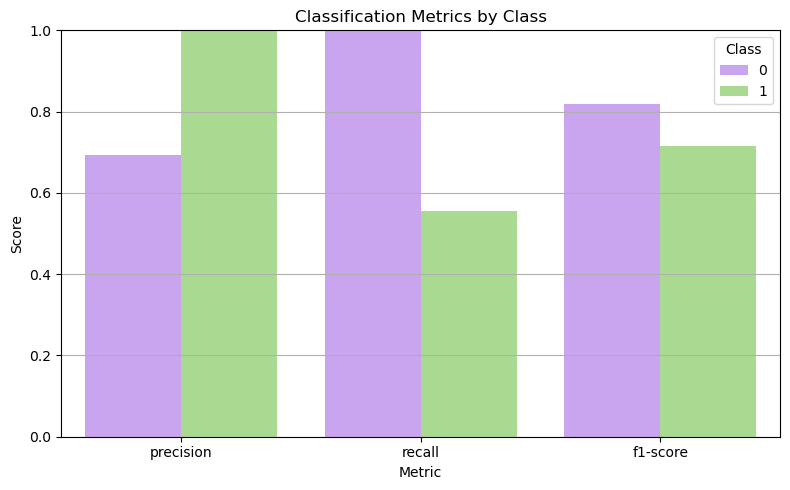

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# 예시 y_true, y_pred는 사용자가 제공한 변수 y_true_bal, y_pred_bal을 사용
report_dict = classification_report(y_true_bal, y_pred_bal, output_dict=True)

# 클래스별 지표 추출
metrics = ['precision', 'recall', 'f1-score']
labels = ['0', '1']

# 데이터 정리
plot_data = {
    'Metric': [],
    'Score': [],
    'Class': []
}

for label in labels:
    for metric in metrics:
        plot_data['Metric'].append(metric)
        plot_data['Score'].append(report_dict[label][metric])
        plot_data['Class'].append(label)

# 시각화
plt.figure(figsize=(8, 5))

# 원하는 색상 지정
custom_palette = {
    '0': "#CA99FB",  # 보라빛 파랑
    '1': '#A6E685'   # 연두색
}

sns.barplot(x='Metric', y='Score', hue='Class', data=pd.DataFrame(plot_data), palette=custom_palette)

plt.title('Classification Metrics by Class')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [8]:
import numpy as np

y_proba = model.predict_proba(X_test_scaled)[:, 1]
for i in range(100):
    print(f"Sample {i}: 확률={y_proba[i]:.3f}, 예측={int(y_proba[i] > 0.5)}, 실제={y_test.iloc[i]}")


Sample 0: 확률=0.007, 예측=0, 실제=0
Sample 1: 확률=0.004, 예측=0, 실제=0
Sample 2: 확률=0.001, 예측=0, 실제=0
Sample 3: 확률=0.724, 예측=1, 실제=0
Sample 4: 확률=0.011, 예측=0, 실제=0
Sample 5: 확률=0.001, 예측=0, 실제=0
Sample 6: 확률=0.002, 예측=0, 실제=0
Sample 7: 확률=0.006, 예측=0, 실제=0
Sample 8: 확률=0.003, 예측=0, 실제=0
Sample 9: 확률=0.075, 예측=0, 실제=0
Sample 10: 확률=0.003, 예측=0, 실제=0
Sample 11: 확률=0.029, 예측=0, 실제=0
Sample 12: 확률=0.016, 예측=0, 실제=0
Sample 13: 확률=0.000, 예측=0, 실제=0
Sample 14: 확률=0.010, 예측=0, 실제=0
Sample 15: 확률=0.001, 예측=0, 실제=0
Sample 16: 확률=0.012, 예측=0, 실제=0
Sample 17: 확률=0.001, 예측=0, 실제=0
Sample 18: 확률=0.130, 예측=0, 실제=0
Sample 19: 확률=0.004, 예측=0, 실제=0
Sample 20: 확률=0.003, 예측=0, 실제=0
Sample 21: 확률=0.111, 예측=0, 실제=0
Sample 22: 확률=0.004, 예측=0, 실제=0
Sample 23: 확률=0.003, 예측=0, 실제=0
Sample 24: 확률=0.001, 예측=0, 실제=0
Sample 25: 확률=0.248, 예측=0, 실제=0
Sample 26: 확률=0.000, 예측=0, 실제=0
Sample 27: 확률=0.009, 예측=0, 실제=0
Sample 28: 확률=0.001, 예측=0, 실제=0
Sample 29: 확률=0.008, 예측=0, 실제=0
Sample 30: 확률=0.003, 예측=0, 실제=0
Sample 31: 확률=0.00

In [7]:
import numpy as np

y_proba = model.predict_proba(X_test_scaled)[:, 1]

# y_test를 Series로 변환 (인덱스 리셋)
y_test_reset = y_test.reset_index(drop=True)

# 실제 값이 1인 샘플의 위치 인덱스 찾기
true_indices = y_test_reset[y_test_reset == 1].index

# 확률 출력
for i in true_indices:
    print(f"Sample {i}: 확률={y_proba[i]:.3f}, 예측={int(y_proba[i] > 0.5)}, 실제={y_test_reset[i]}")


Sample 137: 확률=0.812, 예측=1, 실제=1
Sample 152: 확률=0.040, 예측=0, 실제=1
Sample 184: 확률=0.999, 예측=1, 실제=1
Sample 194: 확률=0.780, 예측=1, 실제=1
Sample 207: 확률=0.737, 예측=1, 실제=1
Sample 246: 확률=0.692, 예측=1, 실제=1
Sample 265: 확률=0.087, 예측=0, 실제=1
Sample 324: 확률=0.996, 예측=1, 실제=1
Sample 344: 확률=0.031, 예측=0, 실제=1
Sample 443: 확률=0.543, 예측=1, 실제=1
Sample 469: 확률=0.004, 예측=0, 실제=1
Sample 678: 확률=0.034, 예측=0, 실제=1
Sample 687: 확률=0.059, 예측=0, 실제=1
Sample 940: 확률=0.648, 예측=1, 실제=1
Sample 1182: 확률=0.990, 예측=1, 실제=1
Sample 1213: 확률=0.999, 예측=1, 실제=1
Sample 1293: 확률=0.624, 예측=1, 실제=1
Sample 1507: 확률=0.964, 예측=1, 실제=1


In [19]:
import pandas as pd

# 1. 원본 데이터 불러오기

output1 = pd.read_csv('/home/kng/Captain/output/output.csv')

# 3. 정규화
output1_scaled = scaler.transform(output1)


# 4. 예측 확률 및 클래스
realproba = model.predict_proba(output1_scaled)[:, 1]
predicted_class = (realproba >= 0.5).astype(int)

# 5. 결과 붙이기 및 저장
output1['goaround_prob'] = realproba
output1['goaround_pred'] = predicted_class

output1
# # 4. 저장
# output1.to_csv('/home/kng/GO-AROUND/csv/output1_with_predictions.csv', index=False)
# print("예측 결과가 'output1_with_predictions.csv'로 저장되었습니다.")


,최저운고(m),기온(0.1c),이슬점온도(0.1c),해면기압 QFF (0.1hPa),현지기압 QFE (0.1hPa),강수량 (0.1mm),2분 평균풍속 (0.1m/s),2분 최대풍속 (0.1m/s),10분 평균풍향 (degree),10분 최우풍향: 평균풍향을 기준으로 시계방향으로 스캔하여 첫번째 값 (degree),10분 평균풍속 (0.1m/s),10분 최대풍속 (0.1m/s),goaround_prob,goaround_pred
0,1600.0,272.0,231.0,9961.0,9934.0,0.0,69.0,27.0,320.0,250.0,46.0,75.0,0.029466,0


In [10]:
from sklearn.metrics import log_loss, roc_auc_score

# 확률 예측
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# 평가지표 계산
logloss = log_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# 출력
print(f"Log Loss         : {logloss:.4f}")
print(f"ROC AUC          : {roc_auc:.4f}")

Log Loss         : 0.0734
ROC AUC          : 0.9361


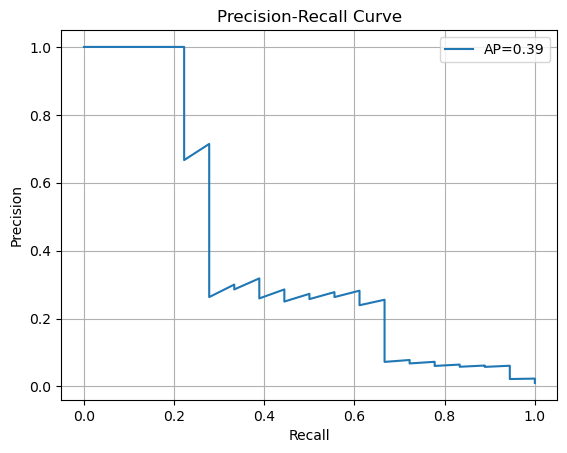

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

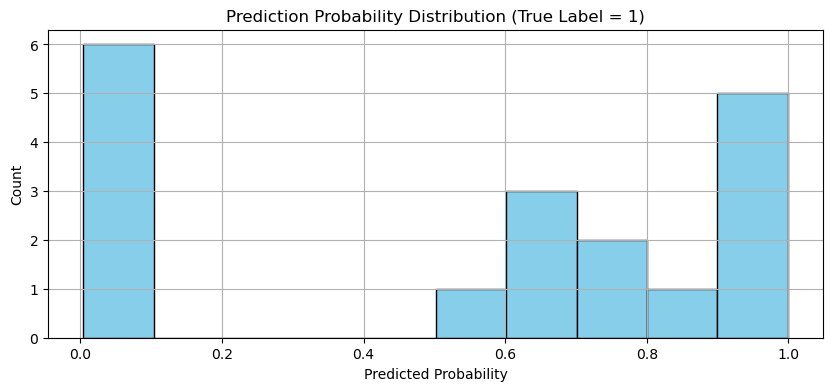

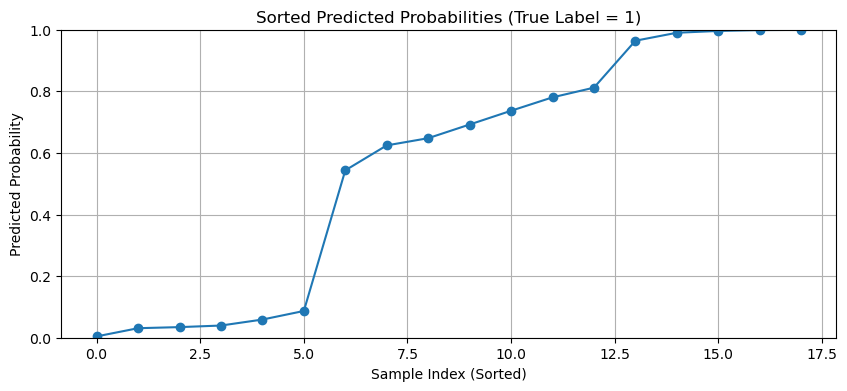

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Predicted probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Reset index for y_test
y_test_reset = y_test.reset_index(drop=True)

# Get indices where true label == 1
true_indices = y_test_reset[y_test_reset == 1].index
true_probs = y_proba[true_indices]

# ------------------------------
# 1. Histogram of probabilities
# ------------------------------
plt.figure(figsize=(10, 4))
plt.hist(true_probs, bins=10, color='skyblue', edgecolor='black')
plt.title("Prediction Probability Distribution (True Label = 1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ------------------------------
# 2. Sorted line plot
# ------------------------------
plt.figure(figsize=(10, 4))
sorted_probs = np.sort(true_probs)
plt.plot(sorted_probs, marker='o')
plt.title("Sorted Predicted Probabilities (True Label = 1)")
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.ylim(0, 1)
plt.show()


In [29]:
import joblib

joblib.dump(model, 'xgb_model_cweight1.1.pkl')


['xgb_model_cweight1.1.pkl']

In [18]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

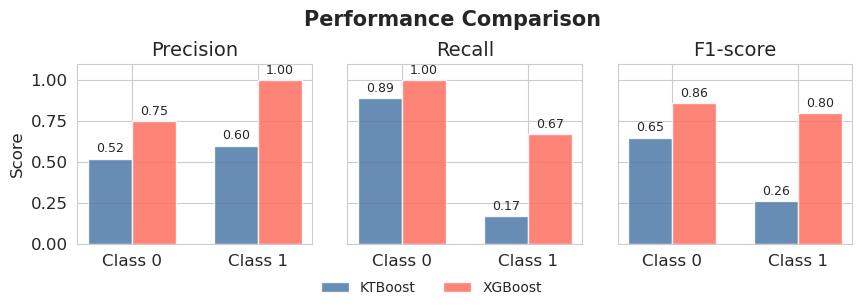

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 스타일 설정
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})

# 데이터
classes = ['Class 0', 'Class 1']

# 첫 번째(다른 논문) 성능
other_precision = [0.52, 0.60]
other_recall = [0.89, 0.17]
other_f1 = [0.65, 0.26]

# 두 번째(우리 논문) 성능
ours_precision = [0.75, 1.00]
ours_recall = [1.00, 0.67]
ours_f1 = [0.86, 0.80]

metrics_data = [
    ('Precision', other_precision, ours_precision),
    ('Recall', other_recall, ours_recall),
    ('F1-score', other_f1, ours_f1)
]

x = np.arange(len(classes))
bar_width = 0.35
colors = ['#4E79A7', '#FF6F61']

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for ax, (metric_name, other_values, ours_values) in zip(axs, metrics_data):
    bars1 = ax.bar(x - bar_width/2, other_values, width=bar_width, label='Other', color=colors[0], alpha=0.85)
    bars2 = ax.bar(x + bar_width/2, ours_values, width=bar_width, label='Ours', color=colors[1], alpha=0.85)

    ax.set_title(metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.1)

    # 값 라벨 표시 (위치 살짝 조정해서 겹침 방지)
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.04, f"{height:.2f}", ha='center', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.04, f"{height:.2f}", ha='center', fontsize=9)

axs[0].set_ylabel("Score")

# 전체 범례 하나만 표시 (아래쪽)
fig.legend(['KTBoost', 'XGBoost'], loc='lower center', ncol=2, frameon=False)

# 간격 조정 (상단 여백 포함)
plt.subplots_adjust(wspace=0.15, bottom=0.2, top=0.8)  # top 값 조정

plt.suptitle("Performance Comparison", fontsize=15, fontweight='bold')
plt.show()
